In [16]:
import numpy as np
import matplotlib.pyplot as plt
import lot
from scipy.stats import norm

In [17]:
#Hyperparameters
N = [200,220]

# Minimal value (avoid zeros)
v_min = 0.02

# First distribution
mu0 = 0.3
std0 = 0.05

mu1 = 0.7
std1 = 0.06

X = np.arange(N[0]) / N[0]
a = norm.pdf(X, loc=mu0, scale=std0)
a += norm.pdf(X, loc=mu1, scale=std1)
a = (a + v_min * a.max())
a = a / a.sum()

# Second distribution
mu2= 0.6
std2= 0.06

mu3 = 0.4
std3 = 0.05

Y = np.arange(N[1]) / N[1]
b = norm.pdf(Y, loc=mu2, scale=std2)
b += norm.pdf(Y, loc=mu3, scale=std3)
b = (b + v_min * b.max())
b = b / b.sum()

# Get the cost matrix
C = np.abs(X[:, None] - Y[None, :]) ** 2
C /= C.max()

The optimal cost is 0.008767026984595184


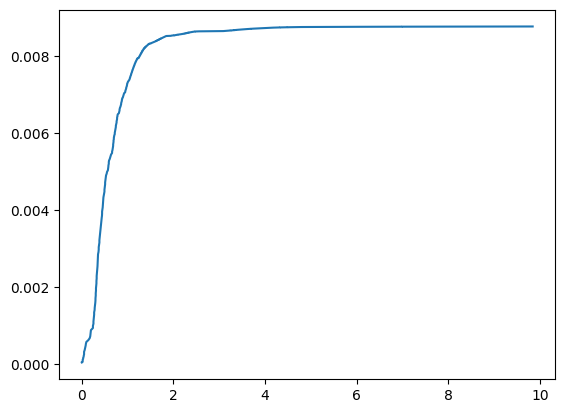

In [18]:
P_opt, _, _, times, cost = lot.sinkhorn(
        a, b, C, epsilon=1e-4, max_iter=3000, delta=1e-9, lbd=0, max_time=50
    )

opt_cost = np.trace(C.T @ P_opt)
print(f"The optimal cost is {opt_cost}")

plt.figure()
plt.plot(times, cost)
plt.show()

In [19]:
## Compute the couplings obtained by Sinkhorn algorithm for multiple regularizations
epsilon_list = np.linspace(1e-3, 1, 100)
OT_Sin = np.zeros_like(epsilon_list)
dist_list_Sin = np.zeros_like(epsilon_list)

for i, epsilon in enumerate(epsilon_list):
    P, _, _, _, _ = lot.sinkhorn(
        a, b, C, epsilon, max_iter=100, delta=1e-9, lbd=0, max_time=50
    )
    OT_cost = np.trace(C.T @ P)
    OT_Sin[i] = OT_cost
    dist_list_Sin[i] = np.linalg.norm(P - P_opt)

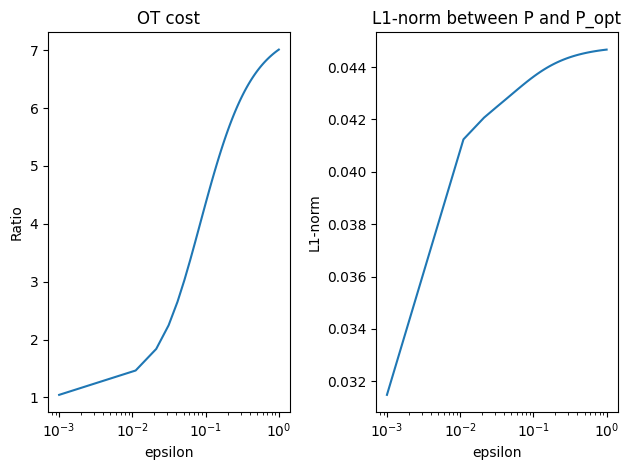

In [20]:
plt.figure()
plt.subplot(121)
plt.title("OT cost")
plt.plot(epsilon_list, OT_Sin / opt_cost)
plt.ylabel("Ratio")
plt.xlabel("epsilon")
plt.semilogx()

plt.subplot(122)
plt.title("L1-norm between P and P_opt")
plt.plot(epsilon_list, dist_list_Sin)
plt.ylabel("L1-norm")
plt.xlabel("epsilon")
plt.semilogx()

plt.tight_layout()
plt.show()

In [21]:
test = np.random.randn(10)
print(test)
print(np.mean((test > 0) & (test < 1)))

[ 2.23895728  0.8327234   1.8813172  -1.97539319 -0.09676839  1.54230374
  0.22142687  0.73367915 -1.48156051  0.70675776]
0.4


In [22]:
## Compute the couplings obtained by LOT for multiple ranks
rank_list = np.append(1, np.arange(2,202,2))
rank_list_short = [10,50,100,200]
g_list = []

OT_LR = []
norm_list_LR = []
concentration_list = []

epsilon=0
alpha=1e-10
gamma=10
max_iter=1000
delta=1e-3
max_time=50
max_iter_dykstra=10000
delta_dykstra=1e-3
lbd_dykstra=0

# Get factorized cost matrices
p = np.power(X, 2)
q = np.power(Y, 2)
C1 = np.vstack((p, np.ones_like(p), -2 * X.T)).T
C2 = np.vstack((np.ones_like(q), q, Y.T)).T

for i, rank in enumerate(rank_list):
    _, _, _, Q, R, g = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    P = Q / g @ R.T
    OT_cost = np.trace(C.T @ P)
    OT_LR.append(OT_cost)

    norm_list_LR.append(np.linalg.norm(P - P_opt))

    concentration = np.mean((g > 1 / (2 * rank)) & (g < 3 / (2 * rank)))
    concentration_list.append(concentration)

    if rank in rank_list_short:
        print(f"Current rank is {rank}")
        g_list.append(g)

C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: divide by zero encountered in log
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))
C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: invalid value encountered in multiply
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))


Break: criterion is nan at iter  192
Break: criterion is nan at iter  158
Break: criterion is nan at iter  152
Break: criterion is nan at iter  142
Break: criterion is nan at iter  138
Current rank is 10
Break: criterion is nan at iter  138
Break: criterion is nan at iter  135
Break: criterion is nan at iter  135
Break: criterion is nan at iter  130
Break: criterion is nan at iter  129
Break: criterion is nan at iter  128
Break: criterion is nan at iter  128
Break: criterion is nan at iter  124
Break: criterion is nan at iter  121
Break: criterion is nan at iter  123
Break: criterion is nan at iter  121
Break: criterion is nan at iter  122
Break: criterion is nan at iter  119
Break: criterion is nan at iter  118
Break: criterion is nan at iter  118
Break: criterion is nan at iter  120
Break: criterion is nan at iter  116
Break: criterion is nan at iter  116
Break: criterion is nan at iter  116
Break: criterion is nan at iter  114
Current rank is 50
Break: criterion is nan at iter  115


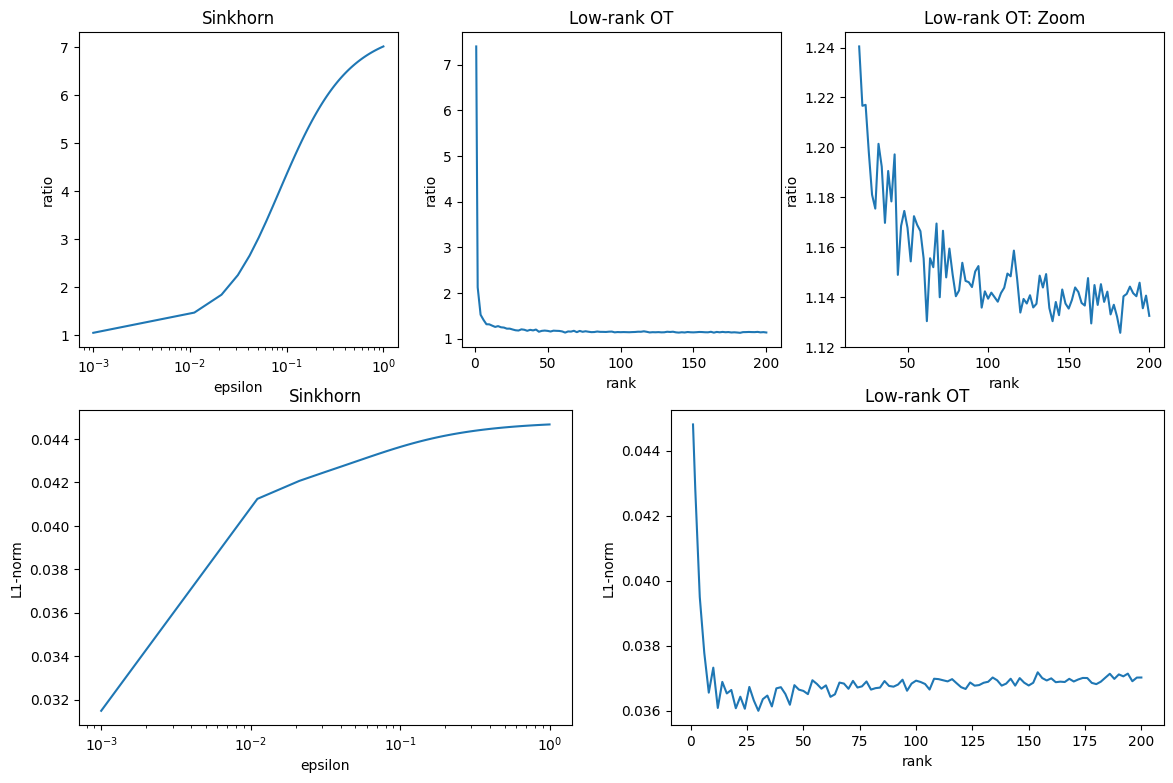

In [23]:
plt.figure(figsize=(14,9))

plt.subplot(223)
plt.title("Sinkhorn")
plt.plot(epsilon_list, dist_list_Sin)
plt.ylabel("L1-norm")
plt.xlabel("epsilon")
plt.semilogx()

plt.subplot(224)
plt.title("Low-rank OT")
plt.ylabel("L1-norm")
plt.xlabel("rank")
plt.plot(rank_list, norm_list_LR)

plt.subplot(231)
plt.title("Sinkhorn")
plt.plot(epsilon_list, OT_Sin / opt_cost)
plt.ylabel("ratio")
plt.xlabel("epsilon")
plt.semilogx()

plt.subplot(232)
plt.title("Low-rank OT")
plt.xlabel("rank")
plt.ylabel("ratio")
plt.plot(rank_list, OT_LR / opt_cost)

plt.subplot(233)
plt.title("Low-rank OT: Zoom")
plt.xlabel("rank")
plt.ylabel("ratio")
plt.plot(rank_list[10:], OT_LR[10:] / opt_cost)

plt.savefig("result/cost_norm_gauss_small")
plt.show()

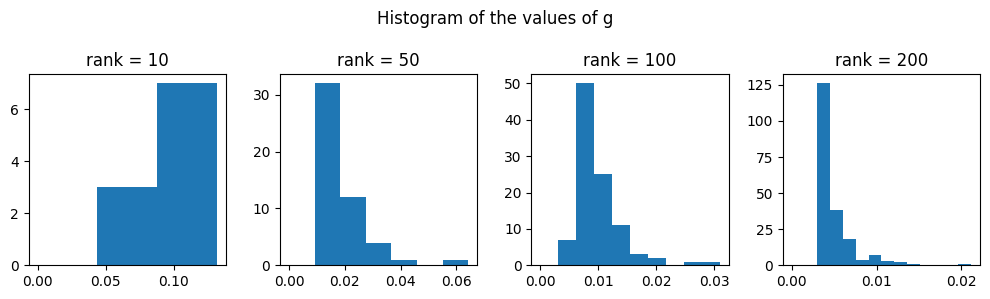

In [24]:
# from scipy.stats import gamma

fig, axs = plt.subplots(1, 4, figsize=(10, 3), constrained_layout=True)
fig.suptitle("Histogram of the values of g")
for i in range(len(rank_list_short)):
    rank = rank_list_short[i]
    hist = g_list[i]

    # mean = np.mean(hist)
    # var = np.var(hist)
    # x = np.linspace(0, max(hist), 100)
    # y = gamma.pdf(x, a=mean**2/var, scale=var/mean)
    # axs[i].plot(x, y)

    axs[i].hist(hist, range=(0, max(hist)), bins=int(np.sqrt(rank)))
    axs[i].set_title(f"rank = {rank}")

plt.tight_layout()
plt.savefig("result/hist")
plt.show()

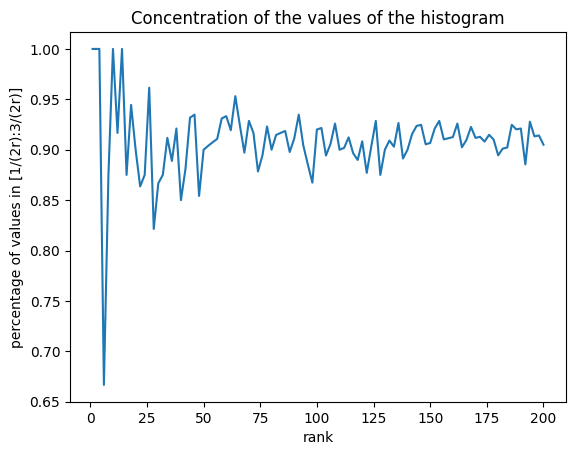

In [26]:
plt.title("Concentration of the values of the histogram")
plt.plot(rank_list, concentration_list)
plt.xlabel("rank")
plt.ylabel("percentage of values in [1/(2r):3/(2r)]")
plt.show()

Looks like it converges towards a Gamma distribution, let us verify that by studying a high number of points.

In [28]:
#Hyperparameters
N = [5000,5500]

# Minimal value (avoid zeros)
v_min = 0.02

# First distribution
mu0 = 0.3
std0 = 0.05

mu1 = 0.7
std1 = 0.06

X = np.arange(N[0]) / N[0]
a = norm.pdf(X, loc=mu0, scale=std0)
a += norm.pdf(X, loc=mu1, scale=std1)
a = (a + v_min * a.max())
a = a / a.sum()

# Second distribution
mu2= 0.6
std2= 0.06

mu3 = 0.4
std3 = 0.05

Y = np.arange(N[1]) / N[1]
b = norm.pdf(Y, loc=mu2, scale=std2)
b += norm.pdf(Y, loc=mu3, scale=std3)
b = (b + v_min * b.max())
b = b / b.sum()

# Get the cost matrix
C = np.abs(X[:, None] - Y[None, :]) ** 2
C /= C.max()

In [29]:
OT_LR = []
dist_list = []
epsilon=0
alpha=1e-10
gamma=10
max_iter=1000
delta=1e-3
max_time=300
max_iter_dykstra=10000
delta_dykstra=1e-3
lbd_dykstra=0

# Get factorized cost matrices
p = np.power(X, 2)
q = np.power(Y, 2)
C1 = np.vstack((p, np.ones_like(p), -2 * X.T)).T
C2 = np.vstack((np.ones_like(q), q, Y.T)).T

In [30]:
rank = 3000

_, cost, times, Q, R, g = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

P = Q / g @ R.T
OT_cost = np.trace(C.T @ P)

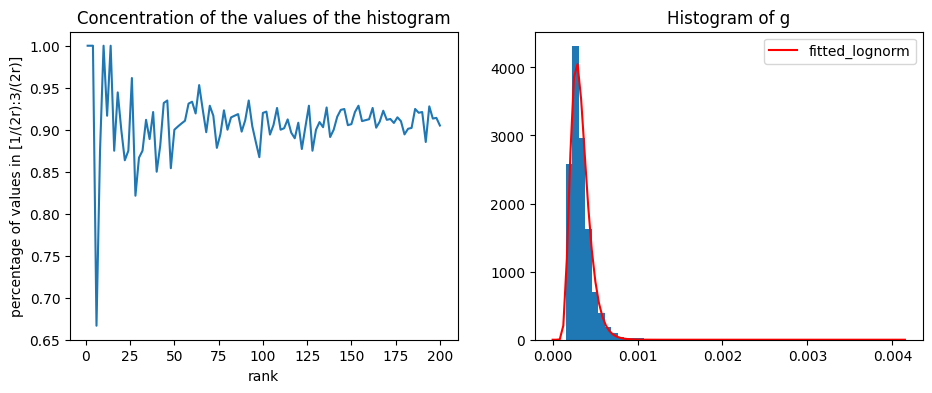

In [35]:
from scipy.stats import lognorm

x = np.linspace(0, max(g), 100)

shape, loc, scale = lognorm.fit(g, floc=0)
lognorm_y = lognorm.pdf(x, shape, loc=loc, scale=scale)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("Concentration of the values of the histogram")
plt.plot(rank_list, concentration_list)
plt.xlabel("rank")
plt.ylabel("percentage of values in [1/(2r):3/(2r)]")

plt.subplot(122)
plt.plot(x, lognorm_y, label="fitted_lognorm", color='r')
plt.hist(g, bins=int(np.sqrt(len(g))), range=(0,max(g)), density=True)
plt.title("Histogram of g")
plt.legend(loc="best")

plt.savefig("result/hist_high_dim")
plt.show()